## В начале как всегда импортируем необходимые библиотеки

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet
import warnings

warnings.filterwarnings("ignore")

## Загружаем и предобрабатываем данные (в частности изменяем формат даты на datetime. Делаем мы это для того, чтобы упростить работу с временными рядами + библиотеке prophet временной ряд необходим в формате datetime)

In [14]:
data = pd.read_csv('data.csv')

print(data.head())
print(data.info())

   index        date  ranknow     open     high      low    close  volume  \
0  21628  2013-12-15       24  0.08385  0.13560  0.04350  0.04470     0.0   
1  21629  2013-12-16       24  0.04485  0.12990  0.02250  0.03075     0.0   
2  21630  2013-12-17       24  0.03105  0.04335  0.01740  0.04035     0.0   
3  21631  2013-12-18       24  0.04005  0.05430  0.03075  0.05430     0.0   
4  21632  2013-12-19       24  0.05925  0.22800  0.04920  0.17430     0.0   

        market  close_ratio  spread  
0   1940697.00     0.012987     0.0  
1   1493994.15     0.076723     0.0  
2   2147991.12     0.883516     0.0  
3   3157053.57     0.999000     0.0  
4  11038835.61     0.699000     0.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1801 entries, 0 to 1800
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        1801 non-null   int64  
 1   date         1801 non-null   object 
 2   ranknow      1801 non-null   

In [15]:
data['date'] = pd.to_datetime(data['date'])  
data.set_index('date', inplace=True)

data.drop(columns=['index', 'ranknow', 'spread'], inplace=True)

In [16]:
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1801 entries, 2013-12-15 to 2018-11-19
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   open         1801 non-null   float64
 1   high         1801 non-null   float64
 2   low          1801 non-null   float64
 3   close        1801 non-null   float64
 4   volume       1801 non-null   float64
 5   market       1801 non-null   float64
 6   close_ratio  1801 non-null   float64
dtypes: float64(7)
memory usage: 112.6 KB
None
               open     high      low    close  volume       market  \
date                                                                  
2013-12-15  0.08385  0.13560  0.04350  0.04470     0.0   1940697.00   
2013-12-16  0.04485  0.12990  0.02250  0.03075     0.0   1493994.15   
2013-12-17  0.03105  0.04335  0.01740  0.04035     0.0   2147991.12   
2013-12-18  0.04005  0.05430  0.03075  0.05430     0.0   3157053.57   
2013-12-19  0.05925  0.22

## Изучим данные визуализируя их график временного ряда

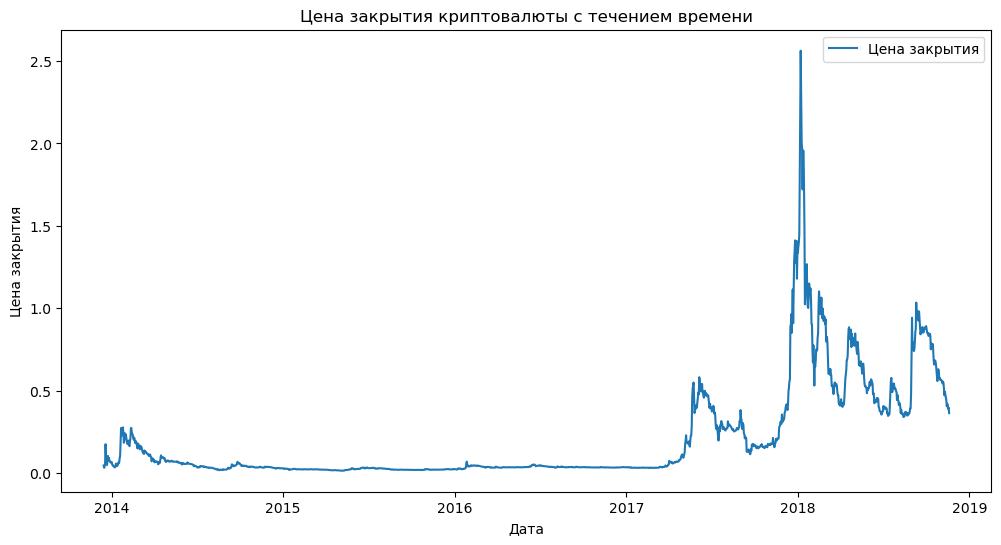

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(data['close'], label='Цена закрытия')
plt.title('Цена закрытия криптовалюты с течением времени')
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.legend()
plt.show()

## При выборе модели для работы с временным рядом выбор был между ARIMA, auto_arima и prophet. Однако результаты первых двух моделей совсем не обрадовали, поэтому я использовал prophet. Подготовим данные для этой модели:

In [18]:
prophet_data = data[['close']].reset_index()
prophet_data.columns = ['ds', 'y']

train_size = int(len(prophet_data) * 0.8)
train_data = prophet_data[:train_size]
test_data = prophet_data[train_size:]

## Обучим модель и сделаем прогноз на тестовой выборке

In [19]:
prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(train_data)

future = prophet_model.make_future_dataframe(periods=len(test_data), freq='D')
forecast = prophet_model.predict(future)

11:01:08 - cmdstanpy - INFO - Chain [1] start processing
11:01:08 - cmdstanpy - INFO - Chain [1] done processing


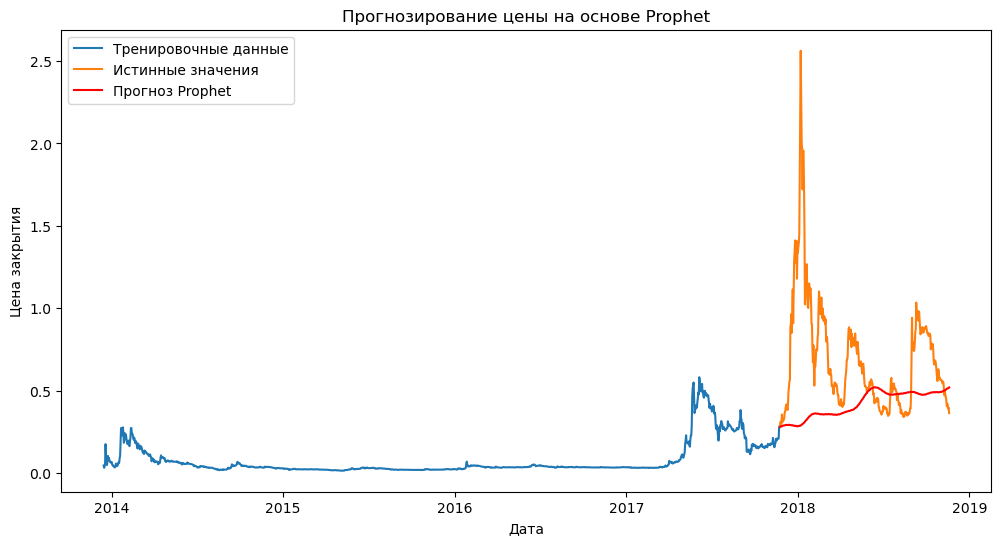

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(train_data['ds'], train_data['y'], label='Тренировочные данные')
plt.plot(test_data['ds'], test_data['y'], label='Истинные значения')
plt.plot(test_data['ds'], forecast['yhat'].iloc[-len(test_data):], color='red', label='Прогноз Prophet')
plt.title('Прогнозирование цены на основе Prophet')
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.legend()
plt.show()

## Конечно от такого предсказания не хочется кричать от удивления и радости проделанной работы модели, но это лучше чем просто прямая линия, которую предсказала arima (результаты первых двух моделей я не включил в отчет в связи с получающейся громоздкостью при показе результатов сразу 3 моделей)

In [21]:
rmse = np.sqrt(mean_squared_error(test_data['y'], forecast['yhat'].iloc[-len(test_data):]))
mae = mean_absolute_error(test_data['y'], forecast['yhat'].iloc[-len(test_data):])
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

RMSE: 0.4750
MAE: 0.3183


## Осталось только сделать предсказание на 10 дней вперед и вывести результат

In [25]:
future_10_days = prophet_model.make_future_dataframe(periods=10, freq='D')
forecast_10_days = prophet_model.predict(future_10_days)

print("Прогноз на 10 дней вперёд:")
print(future_forecast)

Прогноз на 10 дней вперёд:
                yhat
ds                  
2017-11-24  0.278381
2017-11-25  0.280401
2017-11-26  0.281020
2017-11-27  0.282610
2017-11-28  0.284438
2017-11-29  0.286356
2017-11-30  0.286919
2017-12-01  0.286428
2017-12-02  0.287841
2017-12-03  0.287857
